# Calculate Effect Size for HFO Analysis

Using pre-calculated HFOs, determine the effect size of the difference of hfo rates pre and post resection

In [17]:
# auto-format every cell to black
%load_ext lab_black

In [40]:
from pathlib import Path
from mne_bids import (
    read_raw_bids,
    BIDSPath,
    get_entity_vals,
    get_datatypes,
    make_report,
)
from mne_hfo import LineLengthDetector, RMSDetector
from mne_hfo.io import read_annotations
from mne_hfo.posthoc import compute_chs_hfo_rates
from natsort import natsorted

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import pingouin as pg

from sklearn.utils import resample

import ptitprince as pt

from scipy.stats import ranksums
from hyppo.ksample import KSample

In [2]:
np.random.seed(12345)

# Load the data

Find all the paths to the result files for HFO detections. Put them into a dictionary with subjectID keys

In [3]:
bids_root = Path("C:/Users/patri/Johns Hopkins/Adam Li - sickkids")
bids_root = Path('/Users/adam2392/OneDrive - Johns Hopkins/sickkids')

output_path = bids_root / 'derivatives' / 'publication'

output_path.mkdir(exist_ok=True, parents=True)

In [4]:
reference = "average"
detector="linelength"

fpaths = {
    "E1": [],
    "E3": [],
    "E4": [],
    "E5": [],
    "E6": [],
    "E7": [],
    "E8": []
}
sessions = {
    "postresection": "post",
    "preresection": "pre"
}

subjects = get_entity_vals(bids_root, 'subject')
derivative_path = bids_root / "derivatives"
derivative_chain = "hfo/average"
derivative_dir = derivative_path / derivative_chain
for subjectID in subjects:
    for sessionID, taskID in sessions.items():
        bids_paths = BIDSPath(subject=subjectID, session=sessionID,
                          datatype="ieeg",
                          suffix="ieeg", task=taskID,
                          acquisition='ecog',
                          processing=detector,
                          run='01',
                          extension=".vhdr", root=derivative_dir)
        hfo_fpath = str(bids_paths).replace("_ieeg.vhdr", "_desc-hfo_ieeg.tsv")
        if Path(hfo_fpath).exists():
            fpaths[subjectID].append(hfo_fpath)


Load the results into annotation dataframes. Calculate the rate of HFOs per channel and put these lists into a dictionary that separates pre and post resection detections

In [5]:
%%capture
hfos =  {
    "E1": {
        "preresection": None,
        "postresection": None,
    },
    "E3": {
        "preresection": None,
        "postresection": None,
    },
    "E4": {
        "preresection": None,
        "postresection": None,
    },
    "E5": {
        "preresection": None,
        "postresection": None,
    },
    "E6": {
        "preresection": None,
        "postresection": None,
    },
    "E7": {
        "preresection": None,
        "postresection": None,
    },
}
for subject, recordings in fpaths.items():
    if recordings:
        post_tsv = recordings[0]
        pre_tsv = recordings[1]
        # Read tsv files into annotation dataframes
        post_annotations = read_annotations(post_tsv)
        pre_annotations = read_annotations(pre_tsv)
        # Calculate hfos/min for each channel
        hfos[subject]["postresection"] = compute_chs_hfo_rates(post_annotations, 'm')
        hfos[subject]["preresection"] = compute_chs_hfo_rates(pre_annotations, 'm')

In [8]:
%%capture
post_fpath = fpaths["E5"][1]
annotations = read_annotations(post_fpath)

In [9]:
# print the first three HFO annotations in the dataframe
for idx, ann in enumerate(annotations.iterrows()):
    if idx > 3:
        break
    print(ann) 

(0, onset       2.8304
duration    0.0976
label          hfo
channels        C2
sample      5800.0
Name: 0, dtype: object)
(1, onset       3.7942
duration    0.0732
label          hfo
channels        C2
sample      7775.0
Name: 1, dtype: object)
(2, onset       3.8918
duration    0.1098
label          hfo
channels        C2
sample      7975.0
Name: 2, dtype: object)
(3, onset       4.2944
duration    0.0854
label          hfo
channels        C2
sample      8800.0
Name: 3, dtype: object)


# Compute statistical effect size differences

Calculate the effect size between the pre and post resection hfo detection rates. Bootstrap resample (with replacement) 50 times

In [41]:
n_resamples = 50
# Create a dictionary of subjects and effect sizes
data_dict = {"subject": [], "es": [], "p-value": []}

for ind, (subject, sessions) in enumerate(hfos.items()):
    # Bootstrap resample
    effects = np.zeros((n_resamples,))
    pvalues = []
    pre_rates = list(sessions["preresection"].values())
    post_rates = list(sessions["postresection"].values())
    if subject == "E5":
        # subject E5 postresection has no variance in detections. P-value cannot be calculated
        pvalue = np.nan
    else:
        _, pvalue = KSample("Dcorr").test(
            np.array(pre_rates).flatten(), np.array(post_rates).flatten()
        )
    for i in range(n_resamples):
        pre = resample(pre_rates, replace=True, n_samples=len(pre_rates))
        post = resample(post_rates, replace=True, n_samples=len(post_rates))
        effects[i] = pg.compute_effsize(pre, post, eftype="cohen")
        _, pvalue = ranksums(pre, post)
        pvalues.append(pvalue)
    # Add to the dictionary with subject repeated
    data_dict["es"].extend(effects)
    data_dict["subject"].extend([subject] * n_resamples)
    data_dict["p-value"].extend(pvalues)
# Convert dictionary to DataFrame
cohens_int = pd.DataFrame(data_dict)

In [42]:
display(cohens_int.head())

,subject,es,p-value
0,E1,1.272298,1.623658e-10
1,E1,1.319663,1.350993e-09
2,E1,1.672505,2.607568e-12
3,E1,1.304919,6.360150e-10
4,E1,1.149795,3.196313e-09


In [23]:
def first_quartile(x):
    return np.percentile(x, 25)
def third_quartile(x):
    return np.percentile(x, 75)

# print summary of box plot
boxplot_es_summary = cohens_int[['subject', 'es']].groupby('subject').agg({'es': [np.min,np.max, np.median, first_quartile, third_quartile]})
boxplot_es_summary.to_csv(output_path / 'supplemental data tables'/ 'supplemental_boxplot_summary_hfosubjs.csv')

display(boxplot_es_summary)

es                                                  
             amin      amax    median first_quartile third_quartile
subject                                                            
E1       0.858169  1.857346  1.384032       1.168559       1.553104
E3      -0.052395  0.944244  0.400536       0.245618       0.477469
E4      -0.099173  1.085562  0.441813       0.275658       0.634552
E5       1.694089  2.487243  1.991414       1.876940       2.129617
E6      -0.627474  0.036978 -0.352127      -0.445234      -0.258978
E7      -1.245801 -0.648652 -0.949410      -1.000543      -0.840210

## Plot the results

In [37]:
palette = ["gray"] * len(subjects)
palette[0] = "red"

done


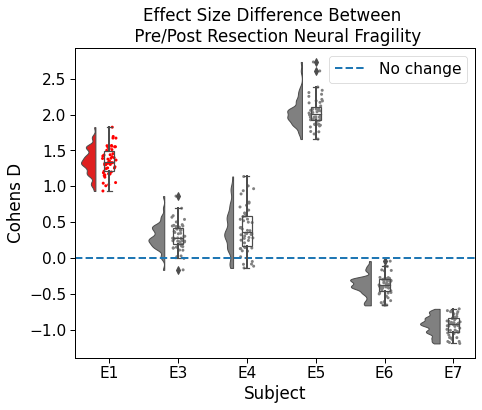

In [53]:
ort = "v"
pal = "Set2"
sigma = 0.2
pal = sns.color_palette(n_colors=1)
sns.set_context("paper", font_scale=1.75)
fig, ax = plt.subplots(figsize=(7, 6))

pt.RainCloud(
    x="subject",
    y="es",
    data=cohens_int,
    palette=palette,
    bw=sigma,
    width_viol=0.6,
    ax=ax,
    orient=ort,
    #     pointplot=True,
)

# ax.axhline(fail_mean, ls="--", lw=2, color="black", label="Failed Avg")

# plot horizontal line
ax.axhline(
    [0],
    ls="--",
    lw=2,
    #            color='black',
    label="No change",
)

ax.legend()
ax.set(
    #     ylim=[-1.5, 1.5],
    xlabel="Subject",
    ylabel=f"Cohens D",  # \n(threshold={threshold})",
    title=f"Effect Size Difference Between \n Pre/Post Resection Neural Fragility",
)

fig.tight_layout()
fig.savefig(
    output_path / f"hfo_es-rainplot-prevspost-{reference}.pdf",
    bbox_inches="tight",
)
print("done")

/Users/adam2392/Documents/sickkids/.venv/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 82.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/adam2392/Documents/sickkids/.venv/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 26.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


done


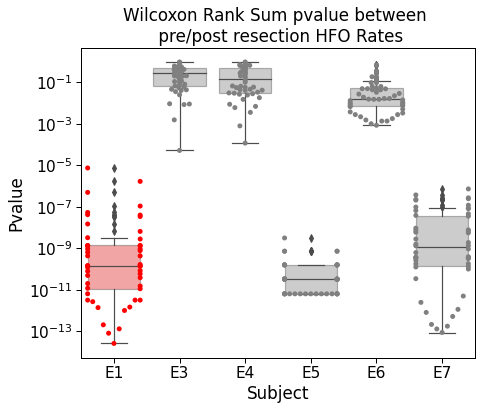

In [54]:
ort = "v"
pal = "Set2"
sigma = 0.2
pal = sns.color_palette(n_colors=1)
sns.set_context("paper", font_scale=1.75)
fig, ax = plt.subplots(figsize=(7, 6))
sns.swarmplot(
    x="subject",
    y="p-value",
    order=natsorted(cohens_int["subject"].unique()),
    #     alpha=0.9,
    palette=palette,
    data=cohens_int,
    ax=ax,
)
sns.boxplot(
    x="subject",
    y="p-value",
    palette=palette,
    order=natsorted(cohens_int["subject"].unique()),
    data=cohens_int,
    ax=ax,
    boxprops=dict(alpha=0.4),
)

ax.set(
    yscale="log",
    xlabel="Subject",
    ylabel="Pvalue",
    title="Wilcoxon Rank Sum pvalue between \n pre/post resection HFO Rates",
)

fig.tight_layout()
fig.savefig(
    output_path / f"hfo_pvalue-rainplot-prevspost-{reference}.pdf",
    bbox_inches="tight",
)
print("done")

Display these results in a figure

In [16]:
grouped_df = cohens_int.groupby('subject')
mean = grouped_df.agg(['mean', np.std])
#stdev = grouped_df.stdev('es')
mean.drop(.columns[i], axis=1)

KeyError: '[4] not found in axis'